# WikiText-2

Downloading, preprocessing and preparing the **WikiText-2** dataset for creating a base-model that will later be used for training the final model. (Thats the goal in mind, the approach and the process may change as the model is built)

This dataset is relatively (very) small, but it will be used for the "pre-pre-training" for the model. It will be used more like a POC before useing the larger dataset.

Dataset specs [found here](https://huggingface.co/datasets/Salesforce/wikitext):
- Total disk size (MB): **17.82**
- NUmber of tokens (million): **2**
- Version: **wikitext-2-v1**
- Data splits
    - train: 36718
    - val: 3760
    - test: 4358

**NOTE**: We are not using the "raw" version of wikitext-2

**Tokenizer done(ish)**: Current version BPETokenizerV2
**Description**: BPETokenizerV2 is a class that allows you to build and process tokens. It follows principles similar to the tokenizer used in OpenAI's GPT-2 model.

## Download and setup dataset

Just download and get some basic understanding of the data.\
It should be pre-processed and will mostly not require much changing at this stage.

In [1]:
# Downloading the dataset
from datasets import load_dataset
ds = load_dataset("Salesforce/wikitext", "wikitext-2-v1")

In [2]:
import random
random.seed(42)

# Get train-val-test splits from 'ds'
train_dataset = ds["train"]
validation_dataset = ds["validation"]
test_dataset = ds["test"]

# Get some info in the splits
print(len(train_dataset), len(validation_dataset), len(test_dataset))

# Random samples from the training dataset
print(random.choice(train_dataset["text"]))

# Checking the data-struct of the 'text' column
print(type(train_dataset["text"]))

# Get some generic info the dataset(s)
print(train_dataset)  # Checking the "columns" of the dataset
# Get the total number of words
c = 0
for sample in train_dataset["text"]:
    c += len(sample.split(" "))
print(f"Found ({c}) words in train-dataset")

36718 3760 4358
 <unk> , Ireland is divided between the Republic of Ireland ( officially named Ireland ) , which covers five @-@ <unk> of the island , and Northern Ireland , which is part of the United Kingdom , in the northeast of the island . In 2011 the population of Ireland was about 6 @.@ 4 million , ranking it the second @-@ most populous island in Europe after Great Britain . Just under 4 @.@ 6 million live in the Republic of Ireland and just over 1 @.@ 8 million live in Northern Ireland . 

<class 'list'>
Dataset({
    features: ['text'],
    num_rows: 36718
})
Found (2112395) words in train-dataset


[INFO] Found (2051910) unique 'words' in train-dataset


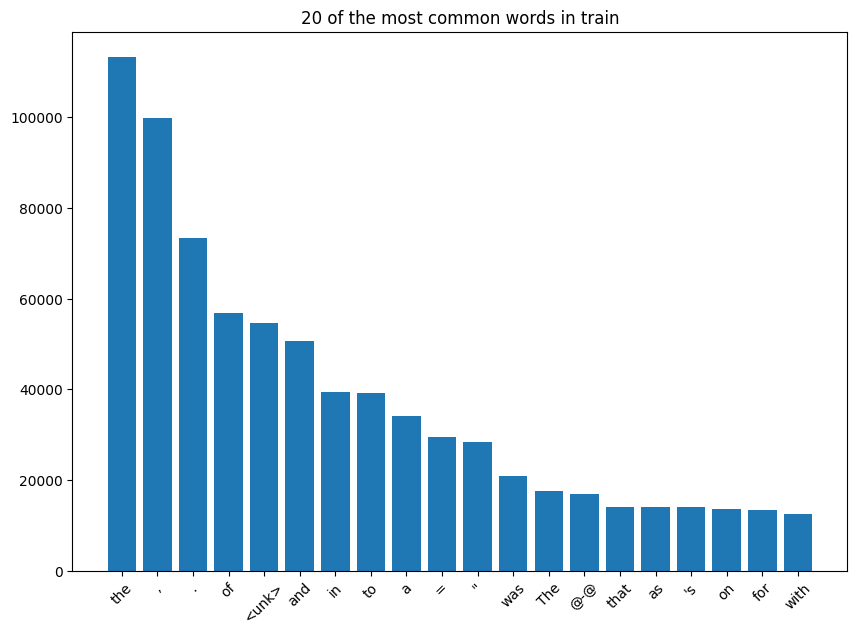

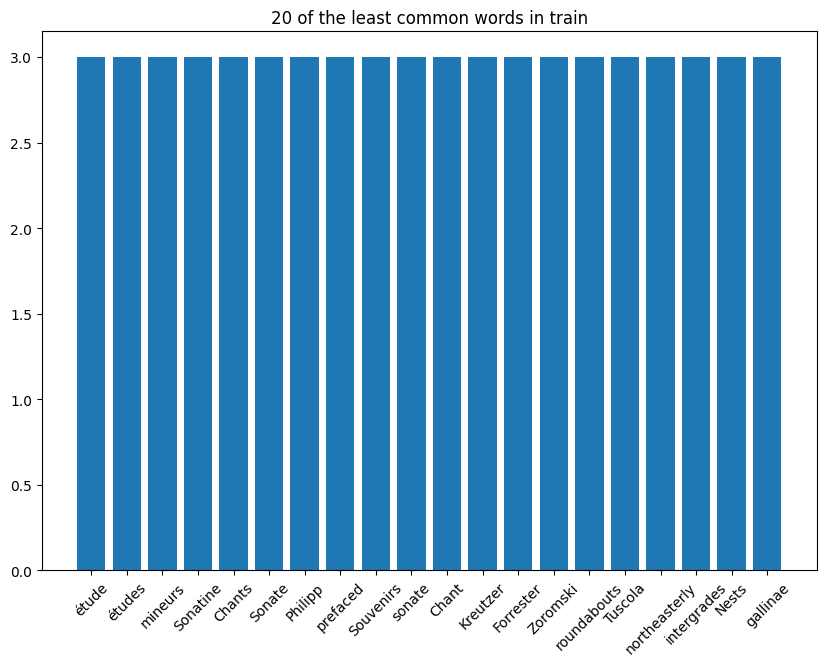

In [3]:
# Understanding word freq's in train

import matplotlib.pyplot as plt
from collections import Counter

words = [word for sample in train_dataset["text"] for word in sample.split()]
print(f"[INFO] Found ({len(words)}) unique 'words' in train-dataset")
counts = Counter(words)
freq = dict(counts)

# Plotting the top-k most common words
k = 20
topk = counts.most_common(k)
topk_words, topk_freq = zip(*topk)
plt.figure(figsize=(10, 7))
plt.bar(topk_words, topk_freq)
plt.xticks(rotation=45)
plt.title(f"{k} of the most common words in train")
plt.show();

# Plotting the top-k least common words
k = 20
topk = counts.most_common()[-k:]
topk_words, topk_freq = zip(*topk)
plt.figure(figsize=(10, 7))
plt.bar(topk_words, topk_freq)
plt.xticks(rotation=45)
plt.title(f"{k} of the least common words in train")
plt.show();


Sentence metrics
Mean: 57.53
Stddev: 77.811
90 percentile: 174.0


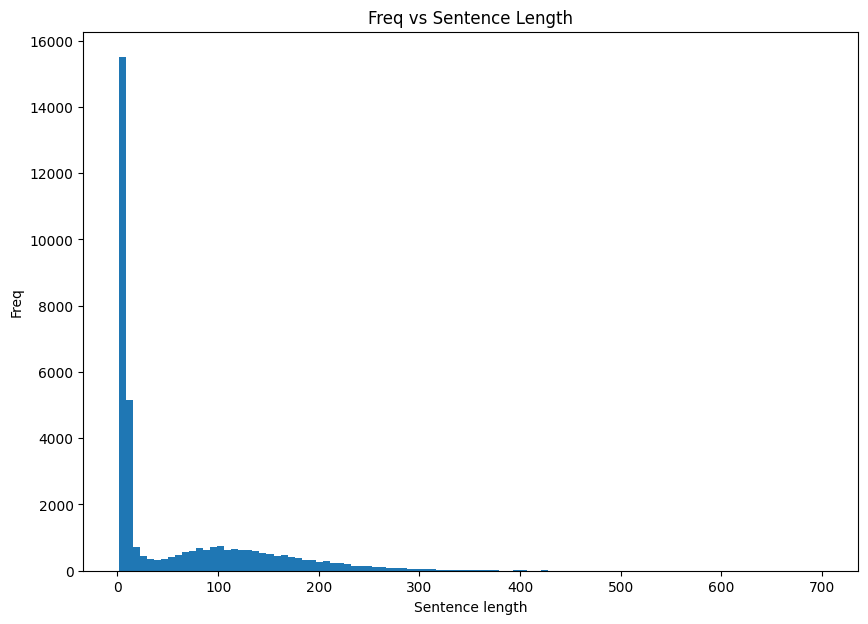

In [4]:
import numpy as np

# Get some metrics
print("Sentence metrics")
_sentence_lens = [len(sample.split(" ")) for sample in train_dataset['text']]

_mean = np.mean(_sentence_lens)
print(f"Mean: {round(_mean, 3)}")
_std = np.std(_sentence_lens)
print(f"Stddev: {round(_std, 3)}")
_90_percentile = np.percentile(_sentence_lens, q=90)
print(f"90 percentile: {round(_90_percentile, 3)}")

# Analyse sentence lengths
plt.figure(figsize=(10, 7))
plt.hist(_sentence_lens, bins=100)
plt.title("Freq vs Sentence Length")
plt.xlabel("Sentence length")
plt.ylabel("Freq")
plt.show();


Looks like the wikitext-2-v1 dataset is well pre-processed and doesn't relly need any kind of filteration as of now.\
This is kinda expected as i'm pivoting away from the plain-text-wikipedia dataset due to pre-processing issues.\
Due to the way I performed tokenization and data-processing when using the plain-text-wikipedia dataset, the model's were takig way too long to train.

## Tokenization

Will use BPE (byte-pair-encoding). After going the throught the tiktoken documentation and a few blog posts, looks like one of the best algorithms to tokenize and prep data for a language model is by using BPE based tokenizers. They allow for shorter sequences while increasing the vocab-size. The model's 'quality' will get better when using BPE as the transformer will understand 'sub-word' level affinities b/w tokens.

Some links that i found useful:
- [Wikipedia](https://en.wikipedia.org/wiki/Byte_pair_encoding)
- [Lei Mao's blog](https://leimao.github.io/blog/Byte-Pair-Encoding/)
- [Animation @ 1:00](https://huggingface.co/learn/nlp-course/en/chapter6/5)
- Asking ChatGPT when I had any questions

### Sample BPE

This is the first time I'm using BPE, so performing all the learning related code here.\
Im using [this video (23:51)](https://www.youtube.com/watch?v=zduSFxRajkE) from Andrej Karpathy to implement it raw.\
Found the above video to be quite helpful in writing the code out and fill-in some gaps in what I had read.

In [5]:
# BPE tokenization
text = "For example, if the model learned the relationship between “old”, “older”, and “oldest”, it does not tell the model anything about the relationship between “smart”, “smarter”, and “smartest”. "
tokens = text.encode("utf-8")
tokens = list(map(int, tokens))

print("---"*5)
print(text)
print(len(text))
print("---"*5)
print(tokens)
print(len(tokens))
print("---"*5)

---------------
For example, if the model learned the relationship between “old”, “older”, and “oldest”, it does not tell the model anything about the relationship between “smart”, “smarter”, and “smartest”. 
192
---------------
[70, 111, 114, 32, 101, 120, 97, 109, 112, 108, 101, 44, 32, 105, 102, 32, 116, 104, 101, 32, 109, 111, 100, 101, 108, 32, 108, 101, 97, 114, 110, 101, 100, 32, 116, 104, 101, 32, 114, 101, 108, 97, 116, 105, 111, 110, 115, 104, 105, 112, 32, 98, 101, 116, 119, 101, 101, 110, 32, 226, 128, 156, 111, 108, 100, 226, 128, 157, 44, 32, 226, 128, 156, 111, 108, 100, 101, 114, 226, 128, 157, 44, 32, 97, 110, 100, 32, 226, 128, 156, 111, 108, 100, 101, 115, 116, 226, 128, 157, 44, 32, 105, 116, 32, 100, 111, 101, 115, 32, 110, 111, 116, 32, 116, 101, 108, 108, 32, 116, 104, 101, 32, 109, 111, 100, 101, 108, 32, 97, 110, 121, 116, 104, 105, 110, 103, 32, 97, 98, 111, 117, 116, 32, 116, 104, 101, 32, 114, 101, 108, 97, 116, 105, 111, 110, 115, 104, 105, 112, 32, 98, 101

In [6]:
# Finding most-freq bytes | Keeping the naming schema similar to Karpathy's video
def get_stats(tokens):
    counts = {}
    for pair in zip(tokens, tokens[1:]):
        counts[pair] = counts.get(pair, 0) + 1
    return counts
stats = get_stats(tokens)
print(sorted(((v,k) for k,v in stats.items()), reverse=True))

[(12, (226, 128)), (6, (128, 157)), (6, (128, 156)), (6, (44, 32)), (6, (32, 226)), (5, (157, 44)), (5, (116, 104)), (5, (101, 108)), (5, (32, 116)), (4, (104, 101)), (4, (101, 32)), (4, (100, 101)), (4, (97, 114)), (4, (32, 97)), (3, (156, 115)), (3, (156, 111)), (3, (116, 226)), (3, (116, 101)), (3, (116, 32)), (3, (115, 109)), (3, (114, 116)), (3, (111, 108)), (3, (109, 97)), (3, (108, 100)), (3, (108, 32)), (3, (104, 105)), (3, (101, 115)), (3, (100, 32)), (3, (97, 110)), (2, (119, 101)), (2, (116, 119)), (2, (116, 105)), (2, (115, 116)), (2, (115, 104)), (2, (114, 226)), (2, (114, 101)), (2, (112, 32)), (2, (111, 110)), (2, (111, 100)), (2, (110, 115)), (2, (110, 100)), (2, (110, 32)), (2, (109, 111)), (2, (108, 101)), (2, (108, 97)), (2, (105, 112)), (2, (105, 111)), (2, (101, 116)), (2, (101, 114)), (2, (101, 110)), (2, (101, 101)), (2, (98, 101)), (2, (97, 116)), (2, (32, 114)), (2, (32, 109)), (2, (32, 105)), (2, (32, 98)), (1, (157, 46)), (1, (121, 116)), (1, (120, 97)), (1, 

In [7]:
# Creating new tokens
def merge(ids: list, pair: tuple, idx: int):
    """
    Updates 'pairs' with new idx when ids is found
    Args:
        ids (list): List of the indices.
        pair (tuple): Pair you want to replace.
        idx (int): Index for the replaced pair
    Returns:
        ids (list): list of ids where 'pair' is replaced with 'idx'
    """
    new_ids = []
    i=0
    # Finding the pair's indices
    while i < len(ids):
        # Replacing with new token (idx)
        if i < len(ids)-1 and (ids[i], ids[i+1]) == pair:
            new_ids.append(idx)
            i+=2
        else:
            new_ids.append(ids[i])
            i+=1
    return new_ids
    
    
# Mini-test case
print(merge([1,2,3,4,5,4,5,4,5,1,2,4,3,4,5], (4,5), 100))
print("---"*5)

# Full run
top_pair = max(stats, key=stats.get)
print(f"Replacing the pair: {top_pair} | char: {chr(top_pair[0]), chr(top_pair[1])}")
tokens2 = merge(tokens, top_pair, 256)
print(tokens2)
print(f"length: {len(tokens2)}")

[1, 2, 3, 100, 100, 100, 1, 2, 4, 3, 100]
---------------
Replacing the pair: (226, 128) | char: ('â', '\x80')
[70, 111, 114, 32, 101, 120, 97, 109, 112, 108, 101, 44, 32, 105, 102, 32, 116, 104, 101, 32, 109, 111, 100, 101, 108, 32, 108, 101, 97, 114, 110, 101, 100, 32, 116, 104, 101, 32, 114, 101, 108, 97, 116, 105, 111, 110, 115, 104, 105, 112, 32, 98, 101, 116, 119, 101, 101, 110, 32, 256, 156, 111, 108, 100, 256, 157, 44, 32, 256, 156, 111, 108, 100, 101, 114, 256, 157, 44, 32, 97, 110, 100, 32, 256, 156, 111, 108, 100, 101, 115, 116, 256, 157, 44, 32, 105, 116, 32, 100, 111, 101, 115, 32, 110, 111, 116, 32, 116, 101, 108, 108, 32, 116, 104, 101, 32, 109, 111, 100, 101, 108, 32, 97, 110, 121, 116, 104, 105, 110, 103, 32, 97, 98, 111, 117, 116, 32, 116, 104, 101, 32, 114, 101, 108, 97, 116, 105, 111, 110, 115, 104, 105, 112, 32, 98, 101, 116, 119, 101, 101, 110, 32, 256, 156, 115, 109, 97, 114, 116, 256, 157, 44, 32, 256, 156, 115, 109, 97, 114, 116, 101, 114, 256, 157, 44, 32, 97,

In [8]:
# Performing the full thing on a larger sample

# Running the whole thing once

text = "Introduction In natural language processing models, the inputs to the model are usually sequences of sentences, such as “I went to New York last week.”. The sequence consists of tokens. In old language models, tokens are usually white-space separated words and punctuations, such as [“i”, “went”, “to”, “new”, “york”, “last”, “week”, “.”]. I remember the word2vec model was using this kind of tokenization method. However, this has some drawbacks. For example, if the model learned the relationship between “old”, “older”, and “oldest”, it does not tell the model anything about the relationship between “smart”, “smarter”, and “smartest”. However, in this case, if we use some subtokens such as “er” and “est”, and the model learned the relationship between “old”, “older”, and “oldest”, it will tell the model some information about the relationship between “smart”, “smarter”, and “smartest”. Now that using subtokens sounds a better tokenization method, how do we engineer these subtokens? Preparing subtokens by ourselves is heuristics and label consuming, thus is not desirable. But information theory comes and saves us again. In information theory, byte pair encoding (BPE) or diagram coding is a simple form of data compression in which the most common pair of consecutive bytes of data is replaced with a byte that does not occur within that data. On Wikipedia, there is a very good example of using BPE on a single string. It was also employed in natural language processing models, such as Transformer (trained on standard WMT 2014 English-German dataset) and GPT-2, to tokenize word sequences. In this blog post, I will talk about how to do byte pair encoding for a whole dataset which consists of sentences or words. Byte Pair Encoding Algorithm Token Learning from Dataset In the paper “Neural Machine Translation of Rare Words with Subword Units” published in 2015, the author has released the source code of doing byte pair encoding for a corpus of words. We count the frequency of each word shown in the corpus. For each word, we append a special stop token “</w>” at the end of the word. We will talk about the motivation behind this later. We then split the word into characters. Initially, the tokens of the word are all of its characters plus the additional “</w>” token. For example, the tokens for word “low” are [“l”, “o”, “w”, “</w>”] in order. So after counting all the words in the dataset, we will get a vocabulary for the tokenized word with its corresponding counts, such as: Encoding and Decoding Decoding is extremely simple, you just have to concatenate all the tokens together and you will get the original whole word. For example, if the encoded sequence is [“the</w>”, “high”, “est</w>”, “moun”, “tain</w>”], we immediately know the decoded sequence “the highest mountain</w>”. How about encoding then? Given word sequence, say, [“the</w>”, “highest</w>”, “mountain</w>”]. We have all the tokens listed in the order from long tokens to short tokens. For each word, we iterate through all the tokens and check if each token is a substring of the word, if so, that token is one of the tokens in the word. In this example, we assume the tokens are [“errrr</w>”, “tain</w>”, “moun”, “est</w>”, “high”, “the</w>”, “a</w>”]. We iterate from the longest token “errrr</w>” to the shortest token “a</w>” trying to replace the substring in each of the word to tokens. Eventually, all the tokens will be iterated, and all the substrings will be replaced to tokens. If there is still substring left but all the tokens were iterated, we replace the remaining subwords to tokens like for unknown tokens. In this example, we get tokenization [“the</w>”] for word “the</w>”, tokenization [“high”, “est</w>”] for word “highest</w>”, and tokenization [“moun”, “tain</w>”] for “mountain</w>”. Encoding is very computationally expensive. In practice, we could pre-tokenize all the words and save how a word should be tokenized in a dictionary. If we saw an unknown word which does not exist in the dictionary. We apply the above encoding method to tokenize the word and add the tokenization of the new word to the dictionary for future reference. Encoding and Decoding Example Here is an example of encoding known and unknown words using tokens learned from the dataset. To get better tokenizations, the number of merges was set to a large number."
tokens = text.encode("utf-8")  # bytes
tokens = list(map(int, tokens))
print(f"Text length: {len(text)} | Tokens length: {len(tokens)}")
print("---"*5)

stats = get_stats(tokens=tokens)
top_pair = max(stats, key=stats.get)
print(f"Looking for pair ids: {top_pair} | Chars: {chr(top_pair[0]), chr(top_pair[1])}")
print(f"Number of pair occurences: {stats[max(stats, key=stats.get)]}")
tokens2 = merge(tokens, top_pair, 256)
print(f"Tokens-2 length: {len(tokens2)}")
print(f"Verified filtering: {len(tokens) - stats[max(stats, key=stats.get)] == len(tokens2)}")
print("---"*5)


# Running it multiple times until desired


Text length: 4364 | Tokens length: 4592
---------------
Looking for pair ids: (101, 32) | Chars: ('e', ' ')
Number of pair occurences: 133
Tokens-2 length: 4459
Verified filtering: True
---------------


In [9]:
# Creating a vocab and compressing 'tokens'
vocab_size = 256 + 20
n_merges = vocab_size - 256
ids = list(tokens)
merges = {}  # (int,int) -> int
for i in range(n_merges):
    stats = get_stats(ids)
    top_pair = max(stats, key=stats.get)
    idx = 256+i
    merges[top_pair] = idx
    ids = merge(ids, top_pair, idx)

# Get some info after "compression"
print(f"Before length: {len(tokens)}")
print(f"After length: {len(ids)}")
print(f"Compression ratio: {(len(tokens) / len(ids)):.3f}")


Before length: 4592
After length: 3346
Compression ratio: 1.372


In [10]:
# Building the vocab (mapping)
vocab = {idx: bytes([idx]) for idx in range(256)}
for (p0, p1), idx in merges.items():
    vocab[idx] = vocab[p0] + vocab[p1]

def decode(ids: list[int]):
    """
    Maps integer into string.
    
    Args:
        ids (List[int]): List of indices.
    Returns:
        (str): Python string.
    """
    tokens = b"".join(vocab[idx] for idx in ids)
    text = tokens.decode("utf-8", errors="replace")
    return text

print(decode([128]))

�


In [11]:
def encode(text: str, verbose: int =0):
    # 1. convert text into tokens (int's)
    # 2. merge tokens until no merges are possible
    tokens = list(text.encode("utf-8"))
    if verbose > 0:
        print(f"{tokens} | {len(tokens)}")
        print("---"*5)
    while len(tokens) >= 2:
        stats = get_stats(tokens)
        pair = min(stats, key=lambda p: merges.get(p, float("inf")))
        if verbose > 0:
            print(f"Found pair: {pair}")
        if pair not in merges:
            if verbose > 0:
                print(f"Pair not merge'able: {pair}, exit")
            break
        idx = merges[pair]
        tokens = merge(tokens, pair, idx)
        if verbose > 0:
            print(f"Replacing pair: {pair} | idx: {idx}")
            print(f"{tokens} | {len(tokens)}")
            print("---"*5)
    return tokens

decode(encode("this is a string"))

'this is a string'

In [12]:
encode("this is a string")

[116, 104, 105, 261, 105, 261, 97, 32, 115, 116, 114, 275]

In [13]:
for idx in encode("this is a string"):
    print(f"'{decode([idx])}'")

't'
'h'
'i'
's '
'i'
's '
'a'
' '
's'
't'
'r'
'ing'


In [14]:
for idx in encode("this is my own tokenizer that kinda works"):
    print(f"'{decode([idx])}'")

't'
'h'
'i'
's '
'i'
's '
'm'
'y'
' '
'o'
'w'
'n'
' t'
'oken'
'i'
'z'
'er'
' th'
'at'
' '
'k'
'in'
'd'
'a'
' '
'w'
'or'
'k'
's'


In [187]:
# All combined into a single class
import warnings

class BPETokenizerV1:
    def __init__(self, texts: list[str]):
        """
        Creates a BPETokenizerV1 instance
        Args:
            texts (List[int]): List of strings, where sterings are texts.
        Returns:
            None
        """
        _text = ""
        for text in texts:
            _text += " " + text
        
        self.text = _text
        self._tokens = self.text.encode("utf-8")
        self.__built = False   # User mustn't change this param, it will break encode/decode otherwise.

    def _get_stats(self, tokens):
        counts = {}
        for pair in zip(tokens, tokens[1:]):
            counts[pair] = counts.get(pair, 0) + 1
        return counts

    def _merge(self,
               ids: list[int],
               pair: tuple[int,int],
               idx: int):
        """
        Merges 'self.tokens' with new idx when pair is found

        Args:
            ids (list[int]): List of the indices.
            pair (Tuple[int, int]): Pair to replace in self.tokens.
            idx (int): Index given to replaced pair.
        Returns:
            List[int]: List of the new (updated) indices.
        """
        new_ids = []
        i=0
        while i < len(ids):
            if i < len(ids)-1 and (ids[i], ids[i+1]) == pair:
                new_ids.append(idx)
                i+=2
            else:
                new_ids.append(ids[i])
                i+=1
        return new_ids

    def __build_tokenizer(self):
        """Builds the tokenizer's vocab"""
        # Checking for errors
        assert type(self._vocab_size) == type(1), f"vocab_size must be an integer, got: {type(self._vocab_size)}"
        assert self._tokens is not None or len(self._tokens) > 0, f"Error converting text into tokens, check the dtype of 'texts' during init"
        assert self._vocab_size >= 256, f"vocab_size must be >= 256, got: {self._vocab_size}.\nNOTE: the first 256 indices are reserved for utf-8 encoding"
        
        n_merges = self._vocab_size - 256
        ids = list(self._tokens)
        merges = {}
        for i in range(n_merges):
            stats = self._get_stats(ids)
            top_pair = max(stats, key=stats.get)
            idx = 256+i
            merges[top_pair] = idx
            ids = self._merge(ids, top_pair, idx)

        print(f"Before length: {len(self._tokens)}")
        print(f"After length: {len(ids)}")
        print(f"Compression ratio: {(len(self._tokens) / len(ids)):.3f}")


        _vocab = {idx: bytes([idx]) for idx in range(256)}
        for (p0, p1), idx in merges.items():
            _vocab[idx] = _vocab[p0] + _vocab[p1]
        
        self._vocab = vocab
        self._merges = merges
        self.__built = True

    def fit(self,
            vocab_size: int,
            texts: list[str] = None):
        """
        NOTE: There is an issue when using .fit(texts != None). Pass 'texts' during initialization.
        
        Builds the tokenizer's vocab if not already.
        When using this function, you may alter the initial text pile by passing the 'new' texts here.
        
        Args:
            texts (List[int]): List of texts (default = None)
        """
        assert self.__built is not True, f"Tokenizer already built"
        
        self._vocab_size = vocab_size
        
        if texts is not None:
            warnings.warn("There is an issue when using .fit(texts != None). Pass 'texts' during initialization.")
            self.text = ""
            for text in texts:
                self.text += " " + text
            self._tokens = self.text.encode("utf-8")
        
        self.__build_tokenizer()

    def decode(self, ids: list[int]):
        """
        Maps integer into string.
        
        Args:
            ids (List[int]): List of indices.
        Returns:
            (str): Python string.
        """
        assert self.__built, f"Build tokenizer before decoding any tokens"
        
        tokens = b"".join(self._vocab[idx] for idx in ids)
        text = tokens.decode("utf-8", errors="replace")
        return text

    def encode(self, text: str, verbose: int = 0):
        assert self.__built, f"Build tokenizer before encoding any text"
        
        tokens = list(text.encode("utf-8"))
        while len(tokens) >= 2:
            stats = self._get_stats(tokens)
            pair = min(stats, key=lambda p: self._merges.get(p, float("inf")))
            if pair not in merges:
                break
            idx = self._merges[pair]
            tokens = self._merge(tokens, pair, idx)
        return tokens


In [188]:
bpe_tokenizer_v1 = BPETokenizerV1(texts=[text])
bpe_tokenizer_v1.fit(vocab_size=256+100)

print("---"*5)
print(bpe_tokenizer_v1.encode("this is a sample"))
print(bpe_tokenizer_v1.decode(bpe_tokenizer_v1.encode("this is a sample")))
print("---"*5)
_temp = 'How about encoding then? Given word sequence'
_temp = 'Sample string with words for a natural language tokenizer'
print(f"Original:\t\t{_temp}")
print(f"Enc-dec:\t\t{bpe_tokenizer_v1.decode(bpe_tokenizer_v1.encode(_temp))}")
print(f"Original length:\t{len(_temp)}")
print(f"Encoded length:\t\t{len(bpe_tokenizer_v1.encode(_temp))}")

Before length: 4593
After length: 2185
Compression ratio: 2.102
---------------
[116, 104, 105, 261, 105, 261, 97, 32, 115, 97, 109, 112, 108, 101]
this is a sample
---------------
Original:		Sample string with words for a natural language tokenizer
Enc-dec:		Sample string with words for a natural language tokenizer
Original length:	57
Encoded length:		45


In [189]:
text == bpe_tokenizer_v1.decode(bpe_tokenizer_v1.encode(text))

True

### BPE-v2

Adding all the 'new' things that were used in the GPT-2 model's tokenizer.

In [340]:
import regex as re
import warnings
from tqdm.auto import tqdm

class BPETokenizerV2:
    def __init__(self, texts: list[str]):
        """
        Creates a BPETokenizerV1 instance using regex-based tokenization.
        Args:
            texts (List[str]): List of input strings.
        """
        self.gpt2_pattern = re.compile(r"'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+")

        _text = " ".join(texts)
        self.splits = self.gpt2_pattern.findall(_text)

        self.split_tokens = [list(tok.encode("utf-8")) for tok in self.splits]

        self.__built = False
        self._vocab = None
        self._merges = None

    def _get_stats(self, tokens):
        """
        Counts occurrences of byte pairs in the tokenized list.
        """
        pairs = {}
        for split in tokens:
            for pair in zip(split, split[1:]):
                pair = tuple(pair)  # FIX: was getting a type error otherwise
                pairs[pair] = pairs.get(pair, 0) + 1
        return pairs

    def _merge(self, tokens, pair, idx):
        """
        Merges a given byte pair in each split separately.
        """
        new_tokens = []
        for split in tokens:
            new_split = []
            i = 0
            while i < len(split):
                if i < len(split) - 1 and (split[i], split[i+1]) == pair:
                    new_split.append(idx)
                    i += 2
                else:
                    new_split.append(split[i])
                    i += 1
            new_tokens.append(new_split)
        return new_tokens

    def __build_tokenizer(self, vocab_size):
        """
        Builds the BPE tokenizer's vocabulary.
        """
        assert vocab_size >= 256, "Vocabulary size must be at least 256 for byte-level tokens."
        
        vocab = {i: bytes([i]) for i in range(256)}
        merges = {}

        n_merges = vocab_size - 256
        ids = self.split_tokens.copy()

        initial_token_count = sum(len(split) for split in ids)

        for i in tqdm(range(n_merges), leave=False, desc="Merging"):
            stats = self._get_stats(ids)
            if not stats:
                self.vocab_size = 256 + i
                break
            top_pair = max(stats, key=stats.get)
            idx = 256 + i
            merges[top_pair] = idx
            ids = self._merge(ids, top_pair, idx)
            vocab[idx] = vocab[top_pair[0]] + vocab[top_pair[1]]

        final_token_count = sum(len(split) for split in ids)

        # Print some info after tokenizer is built
        print(f"Before length: {initial_token_count}")
        print(f"After length: {final_token_count}")
        print(f"Compression ratio: {(initial_token_count / final_token_count):.3f}")

        self._vocab = vocab
        self._merges = merges
        self.__built = True

    def fit(self, vocab_size: int, texts: list[str] = None):
        """
        Builds the tokenizer's vocabulary using the given texts.
        """
        if texts:
            warnings.warn("Using .fit with new texts is discouraged. Pass texts during initialization.")
            _text = " ".join(texts)
            self.splits = self.gpt2_pattern.findall(_text)
            self.split_tokens = [list(tok.encode("utf-8")) for tok in self.splits]

        self.__build_tokenizer(vocab_size)

    def encode(self, text: str):
        """
        Encodes a given text into a sequence of token IDs.
        """
        assert self.__built, "Tokenizer must be built using `fit` before encoding."

        # Step 1: Split and encode text using regex and bytes
        splits = self.gpt2_pattern.findall(text)
        split_tokens = [list(tok.encode("utf-8")) for tok in splits]

        encoded_ids = []
        for tokens in split_tokens:
            while len(tokens) >= 2:
                stats = self._get_stats([tokens])  # Compute within-split stats
                pair = min(stats, key=lambda p: self._merges.get(p, float('inf')), default=None)
                if pair is None or pair not in self._merges:
                    break
                idx = self._merges[pair]
                tokens = self._merge([tokens], pair, idx)[0]  # Apply merge
            encoded_ids.extend(tokens)  # Append the final tokens to the result

        return encoded_ids

    def decode(self, ids: list[int]):
        """
        Decodes a list of token IDs back into a string.
        """
        assert self.__built, "Tokenizer must be built using `fit` before decoding."

        tokens = b"".join(self._vocab[idx] for idx in ids)
        text = tokens.decode("utf-8", errors="replace")
        return text
    
    def save(self, file_path: str):
        """
        Save the tokenizer's vocab and merges to a file.
        Args:
            file_path: Path to save at.
        """
        with open(file_path, 'wb') as f:
            pickle.dump({'vocab': self._vocab, 'merges': self._merges}, f)
        print(f"[INFO] Tokenizer saved to {file_path}")

    @classmethod
    def load(cls, file_path: str):
        """
        Load the tokenizer from a saved file.
        Args:
            file_path: Path to load from.
        """
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Create a new tokenizer instance and set the vocab and merges
        tokenizer = cls()
        tokenizer._vocab = data['vocab']
        tokenizer._merges = data['merges']
        tokenizer.__built = True
        print(f"[INFO] Tokenizer loaded from {file_path}")
        return tokenizer


In [341]:
bpe_tokenizer_v2 = BPETokenizerV2([text, " ", "  ", "   ", "    "])
bpe_tokenizer_v2.fit(vocab_size=1024*2)
print("---"*5)

_temp = 'Sample string with words for a natural       language tokenizer'
print(f"Original:\t\t{_temp}")
print(f"Enc-dec:\t\t{bpe_tokenizer_v2.decode(bpe_tokenizer_v2.encode(_temp))}")
print(f"Original length:\t{len(_temp.split(' '))}")
print(f"Encoded length:\t\t{len(bpe_tokenizer_v2.encode(_temp))}")

Merging:   0%|          | 0/1792 [00:00<?, ?it/s]

Before length: 4606
After length: 945
Compression ratio: 4.874
---------------
Original:		Sample string with words for a natural       language tokenizer
Enc-dec:		Sample string with words for a natural       language tokenizer
Original length:	15
Encoded length:		13


In [342]:
_temp = 'Sample string with words for a natural       language tokenizer '
output = ""
for n, i in enumerate(bpe_tokenizer_v2.encode(_temp)):
    col = "\033[101m"
    if n % 2 == 0:
        col = "\033[106m"
    output += f"{col}{bpe_tokenizer_v2.decode([i])}"
print(output)

Sample string with words for a natural       language tokenizer 


### Tokenizer for wikitext-2-v1

In [343]:
tokenizer = BPETokenizerV2(texts=train_dataset["text"])
tokenizer.fit(vocab_size=1024*2)

Merging:   0%|          | 0/1792 [00:00<?, ?it/s]

Before length: 10807963
After length: 3519793
Compression ratio: 3.071


In [344]:
validation_dataset["text"][23] == tokenizer.decode(tokenizer.encode(validation_dataset["text"][23]))

True

In [345]:
for i in tokenizer.encode("Im unable to create my own tokenizer"):
    print(f"'{tokenizer.decode([i])}' : {i}")
    print("---")

'I' : 73
---
'm' : 109
---
' un' : 522
---
'able' : 699
---
' to' : 292
---
' cre' : 993
---
'ate' : 432
---
' my' : 1577
---
' own' : 1098
---
' to' : 292
---
'k' : 107
---
'en' : 277
---
'iz' : 636
---
'er' : 261
---


In [346]:
print(len(tokenizer.encode(" company is a company that is popular in the United States of America Indian")))
print(len(" company is a company that is popular in the United States of America Indian".split(" ")))

15
15


In [350]:
for i in tokenizer.encode(" company is a company that is popular in the United States of America Land country"):
    print(f"'{tokenizer.decode([i])}' : {i}")
    print("---")

' company' : 1597
---
' is' : 364
---
' a' : 258
---
' company' : 1597
---
' that' : 355
---
' is' : 364
---
' popular' : 1770
---
' in' : 282
---
' the' : 260
---
' United' : 955
---
' States' : 1249
---
' of' : 279
---
' America' : 1874
---
' L' : 390
---
'and' : 383
---
' country' : 1813
---


In [352]:
import pickle
tokenizer.save("./bpe_tokenizer_v1_train_dataset.pth")

[INFO] Tokenizer saved to ./bpe_tokenizer_v1_train_dataset.pth


In [361]:
import pickle
import regex as re

def load_bpe_tokenizer(file_path: str, tokenizer_class):
    """
    Load the BPE tokenizer from a saved file without requiring texts in the constructor.
    Args:
        file_path (str): Path to the saved tokenizer file.
        tokenizer_class: The class of the tokenizer to instantiate.
    Returns:
        tokenizer_class: A loaded tokenizer instance with vocab and merges.
    """
    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    # Create an uninitialized instance of the tokenizer
    tokenizer = object.__new__(tokenizer_class)

    # Set vocab and merges directly
    tokenizer._vocab = data['vocab']
    tokenizer._merges = data['merges']
    setattr(tokenizer, '_BPETokenizerV2__built', True)  # Fix for name mangling

    # Initialize necessary attributes that are otherwise set in __init__
    tokenizer.gpt2_pattern = re.compile(r"'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+")
    print(f"[INFO] Tokenizer loaded from {file_path}")
    return tokenizer


In [362]:
# Loading the tokenizer into a new instance
loaded_tokenizer = load_bpe_tokenizer("./bpe_tokenizer_v1_train_dataset.pth", BPETokenizerV2)

[INFO] Tokenizer loaded from ./bpe_tokenizer_v1_train_dataset.pth


In [369]:
# Testing the loaded tokenizer
print(loaded_tokenizer.decode(loaded_tokenizer.encode(validation_dataset["text"][23])) == tokenizer.decode(tokenizer.encode(validation_dataset["text"][23])))
print(validation_dataset["text"][23] == loaded_tokenizer.decode(loaded_tokenizer.encode(validation_dataset["text"][23])))

True
True


In [388]:
for i in loaded_tokenizer.encode("Rank Nouns Verbs Adjectives Prepositions Others time be good to the person have new of and year do first in a way say last for that day get long on I thing make great with it man go little at not world know own by he life take other from as hand see old up you part come right about this child"):
    print(f"'{loaded_tokenizer.decode([i])}'")

'R'
'ank'
' N'
'oun'
's'
' V'
'er'
'bs'
' Ad'
'ject'
'ives'
' P'
're'
'p'
'os'
'itions'
' O'
'ther'
's'
' time'
' be'
' good'
' to'
' the'
' person'
' have'
' new'
' of'
' and'
' year'
' do'
' first'
' in'
' a'
' way'
' say'
' last'
' for'
' that'
' day'
' g'
'et'
' long'
' on'
' I'
' th'
'ing'
' make'
' great'
' with'
' it'
' man'
' go'
' lit'
'tle'
' at'
' not'
' world'
' kn'
'ow'
' own'
' by'
' he'
' life'
' take'
' other'
' from'
' as'
' hand'
' see'
' old'
' up'
' you'
' part'
' com'
'e'
' right'
' about'
' this'
' child'
